# Notebook 2. Alternating Least Squares

Made by:
- Ivan Chernakov
- BS21-DS-02
- i.chernakov@innopolis.university

In this notebook we will use the Alternating Least Squares algorithm to make recommendations. This algorithm is based on the matrix factorization technique, which consists of decomposing the user-item matrix into two matrices, one for users and one for items.

The overall approach was guied by this [tutorial](https://www.kaggle.com/code/pauloyuncha/recommendation-system-from-zero-to-hero-2?scriptVersionId=123152617).

imports

In [ ]:
# %%capture
# !pip install implicit

In [3]:
from utils import *

from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
import pandas as pd

In [4]:
data = load_movielens_ratings('u.data')

def split_dataframe(data):
    data = data.sample(frac=1, random_state=42)
    n = int(len(data) * 0.8)
    return data.iloc[:n], data.iloc[n:]

ratings_base, ratings_test = split_dataframe(data)


display(ratings_base.head())
display(ratings_test.head())

,user_id,item_id,rating,timestamp
75721,877,381,4,882677345
80184,815,602,3,878694269
19864,94,431,4,891721716
76699,416,875,2,876696938
92991,500,182,2,883873556


,user_id,item_id,rating,timestamp
98877,907,143,5,880159982
24044,371,210,4,880435313
48435,218,42,4,877488546
72179,829,170,4,881698933
80645,733,277,1,879536523


In [5]:
print(ratings_base.shape)
print(ratings_test.shape)

(80000, 4)
(20000, 4)


### Alternating Least Squares

Here to make matrix we need to get maximum values from data

In [7]:
amount_users = ratings_base.user_id.values
amount_movies = ratings_base.item_id.values

max_shape = max(max(amount_users), max(amount_movies))+1
print(max_shape)

1683


In [8]:
ratings_base_sparse_item = csr_matrix((ratings_base.rating, (ratings_base.item_id, ratings_base.user_id)), shape=(max_shape, max_shape))
ratings_base_sparse_user = csr_matrix((ratings_base.rating, (ratings_base.user_id, ratings_base.item_id)), shape=(max_shape, max_shape))

In [9]:
model = AlternatingLeastSquares(factors=10, regularization=0.4, iterations=40)

data_conf = (ratings_base_sparse_item * 33).astype('double')
model.fit(data_conf)

C:\Users\ivanc\AppData\Local\Programs\Python\Python311\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 6 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/40 [00:00<?, ?it/s]

In [70]:
# Evaluate
results = []
def evaluate_model(model, rating_test):
    #Get Recommendations
    list_rec = []
    watched_movies = []
    for user_id in rating_test['user_id'].unique():
        
        
        recommended, score = model.recommend(
            userid = user_id,
            user_items=ratings_base_sparse_user,
            N=250,
            filter_already_liked_items=False
        )

        watched_movies.append(ratings_base[ratings_base['user_id'] == user_id]['item_id'].unique())
        list_rec.append([user_id, recommended])
        
    candidates = pd.DataFrame(list_rec, columns=['user_id', 'recommendations'])

    #Evaluate
    candidates = candidates.merge(ratings_test, on='user_id', how='left')
    candidates['hit'] = candidates.apply(lambda x: x.item_id in x.recommendations, axis=1)
    


    print('Hit Rate: ', candidates.hit.mean())
    
    return candidates.hit.mean()

In [71]:
import pickle

# change directory to save model
os.chdir(os.path.join(os.getcwd(), '../models'))
with open('ASL.pkl', 'wb') as f:
    pickle.dump(model, f)

In [72]:
import numpy as np

tests = ['u1.test', 'u2.test', 'u3.test', 'u4.test', 'u5.test']
hits = []

for test in tests:
    data = load_movielens_ratings(test)
    ratings_base, ratings_test = split_dataframe(data)
    ratings_base_sparse_item = csr_matrix((ratings_base.rating, (ratings_base.item_id, ratings_base.user_id)), shape=(max_shape, max_shape))
    ratings_base_sparse_user = csr_matrix((ratings_base.rating, (ratings_base.user_id, ratings_base.item_id)), shape=(max_shape, max_shape))
    model = AlternatingLeastSquares(factors=10, regularization=0.4, iterations=40)
    data_conf = (ratings_base_sparse_item * 40).astype('double')
    model.fit(data_conf)
    print(test)
    hits.append(evaluate_model(model, ratings_test))

    
print('Mean Hit Rate: ', np.mean(hits))

  0%|          | 0/40 [00:00<?, ?it/s]

u1.test
Hit Rate:  0.3505


  0%|          | 0/40 [00:00<?, ?it/s]

u2.test
Hit Rate:  0.28575


  0%|          | 0/40 [00:00<?, ?it/s]

u3.test
Hit Rate:  0.251


  0%|          | 0/40 [00:00<?, ?it/s]

u4.test
Hit Rate:  0.2255


  0%|          | 0/40 [00:00<?, ?it/s]

u5.test
Hit Rate:  0.2145
Mean Hit Rate:  0.26544999999999996


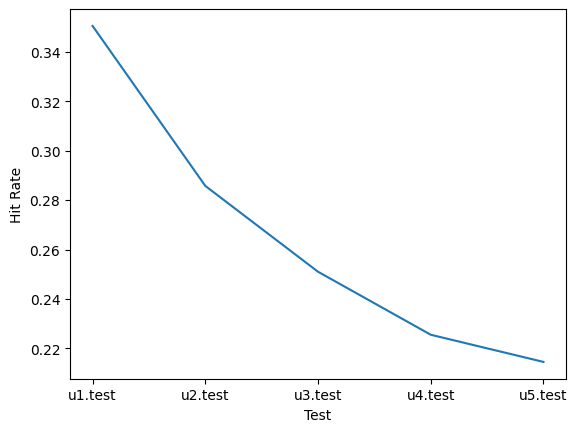

In [73]:
# plot hits 
import matplotlib.pyplot as plt

plt.plot(tests, hits)
plt.xlabel('Test')
plt.ylabel('Hit Rate')
plt.show()